purpose: generate network colocalization values for Locomotor-Externalizing network and compare NPS scores

# set-up

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [2]:
random_seed=random.seed(211)

In [3]:
save_fig=True

In [4]:
#whether to rerun the significance analysis for network colocalization
rerun_colocalization=False

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [6]:
plt.rcParams.update({'font.size': 16})

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [8]:
tissue_network=True

In [12]:
if tissue_network==False:
    interactome_name='PCNet2.0'
    interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
    all_nodes=list(interactome.nodes())
    # pre calculate the matricies used for network propagation
    print('\ncalculating w_prime')
    w_prime = netprop.get_normalized_adjacency_matrix(interactome, conserve_heat=True)
    
    print('\ncalculating w_double_prime')
    w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)
else:
    netdir='tissue_networks/intermediate/'
    tissue='global'
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]

# import NPS scores and seed genes

In [46]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol']) 
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR'])

In [16]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [ ]:
if tissue_network:
    seed_dict={k: set(hgnc[hgnc.symbol.isin(v)]['entrez_id']) for k, v in seed_dict.items()}

In [50]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)
NPS_dict.keys()

dict_keys(['ext_top500_hb_tissue_global_top', 'loco_final_cf_FDR_hb_tissue_global_top'])

# choose datasets for analysis

In [51]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_final_cf'
trait_h='ext'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

if (trait_h=='addict-rf'):
    shared_colour='shared_addict-rf'
    shared_colour_alt='shared_alt_addict-rf'
    
else:
    shared_colour='shared'
    shared_colour_alt='shared_alt'

# compare seed genes

In [52]:
seed_r.intersection(seed_h)

{'1135', '166752', '2185', '2555', '257194', '57484', '8467', '9785'}

{'57484', '2185', '2555', '166752', '257194', '9785', '1135', '8467'}


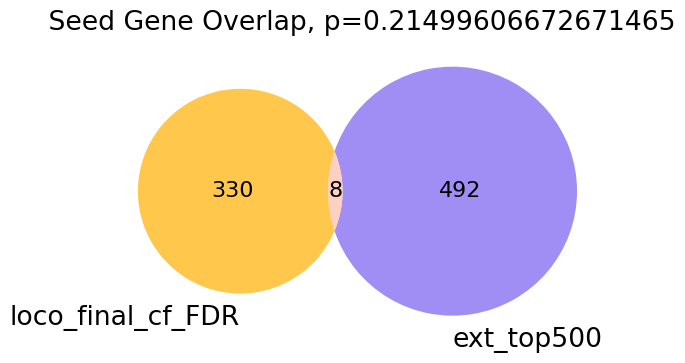

In [53]:
venn_seeds(seed_r, seed_h, label_r, label_h, colour_dict[trait_r],colour_dict[trait_h],all_nodes,interactome_name, savefig=save_fig)

# compare stats

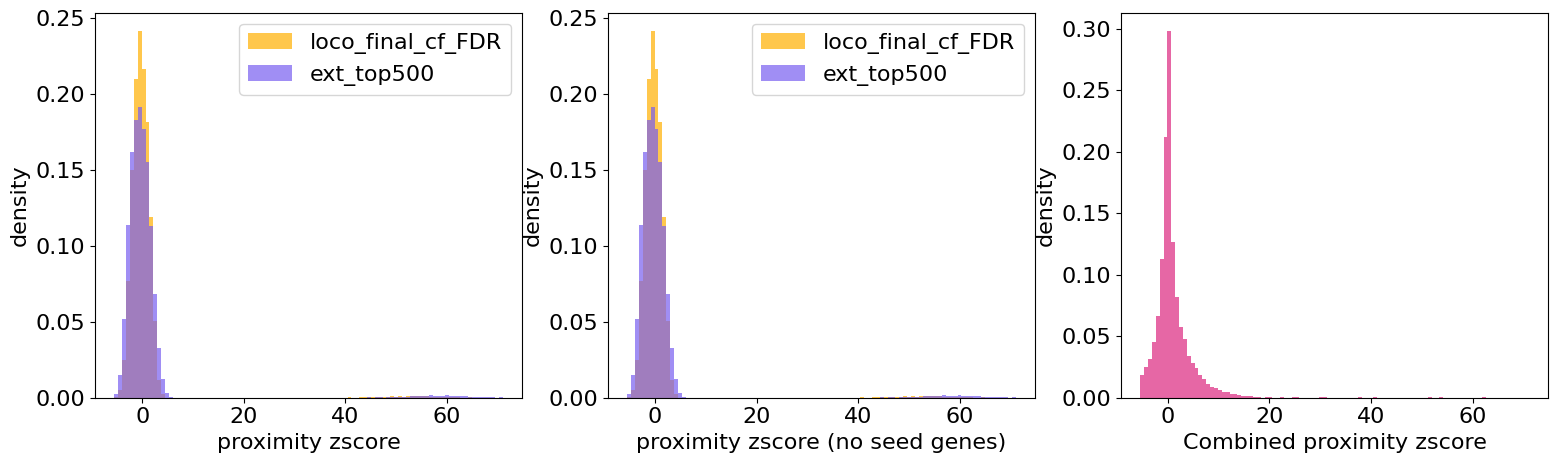

In [54]:
#import rare seed gene list and NPS scores
plt_histogram(tblr=NPS_r, tblc=NPS_h, 
              tblr_label=label_r, tblc_label=label_h,
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict[shared_colour],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)


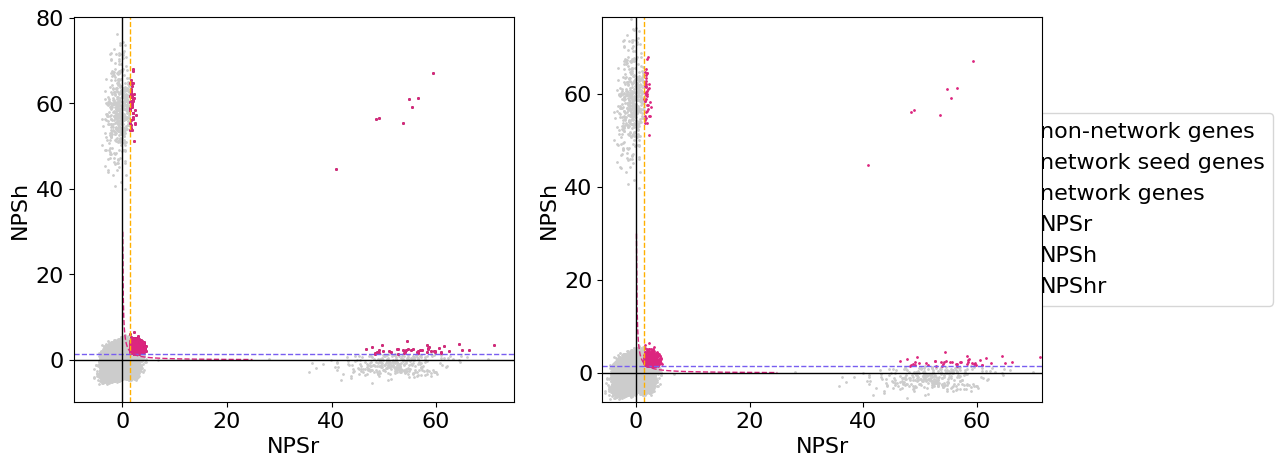

In [55]:
#import rare seed gene list and NPS scores
plt_scatter_NPS(tblr=NPS_r, tblc=NPS_h, 
              tblr_label='NPSr', tblc_label='NPSh',
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict[shared_colour],colour_nonseed=colour_dict[shared_colour_alt],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_scatter'+'_'+label_r+'_'+label_h+'_'+interactome_name)


In [56]:
zlist=[cut_comb]
z12list=[cut_single]

In [57]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,4,5,6,7,8,9,10]
z12list = [1,1.5,2,3,4,5]


In [58]:
rerun_colocalization=False

In [59]:
coloc_filename=f'colocalization_scores/colocScore_{label_r}_{label_h}_{interactome_name}.tsv'
if rerun_colocalization | (not (os.path.exists(coloc_filename))):
    print('analyzing colocalization')
    netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(NPS_r,NPS_h,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=False)
    #netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
    print(netcoloc_enrichment_df)
    netcoloc_enrichment_df['rat_dataset']=label_r
    netcoloc_enrichment_df['human_dataset']=label_h
    if save_fig:
        netcoloc_enrichment_df.to_csv(coloc_filename,sep='\t',index=False)
else:
    print(f'reading in {coloc_filename}')
    netcoloc_enrichment_df=pd.read_csv(coloc_filename,sep='\t')
pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cut_comb) & (netcoloc_enrichment_df['z_12']==cut_single)]['empirical_p'])

analyzing colocalization
    z_comb  z_12  observed_overlap  expected_overlap_mean  \
0        1   1.0              1659                1521.19   
1        1   1.5               813                 681.53   
2        1   2.0               405                 261.66   
3        1   3.0                62                  32.03   
4        1   4.0                10                   9.84   
5        1   5.0                 8                   7.26   
6        2   1.0              1459                1284.03   
7        2   1.5               813                 685.70   
8        2   2.0               405                 264.80   
9        2   3.0                62                  32.60   
10       2   4.0                10                  10.29   
11       2   5.0                 8                   6.73   
12       3   1.0              1090                 922.26   
13       3   1.5               776                 639.72   
14       3   2.0               405                 261.49   

1.5
776


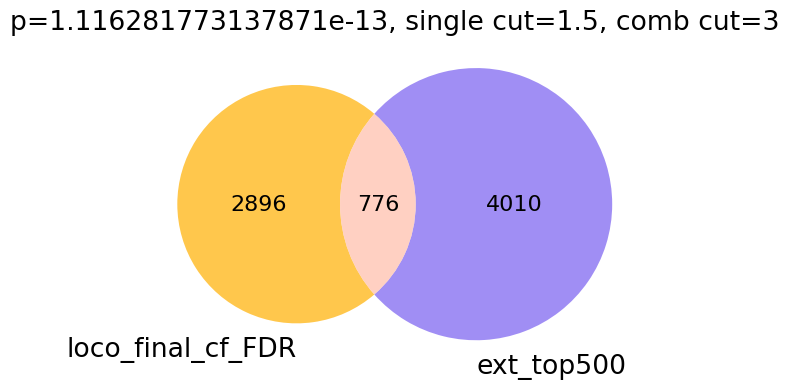

In [60]:
venn_net(tblr=NPS_r,tblc=NPS_h, tblr_label=label_r,tblc_label= label_h,p_net_overlap=pOverlap,
         colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict['shared'],
         tblr_lim=cut_single, tblc_lim=cut_single, comb_lim=3, savefig=save_fig)

In [61]:
tbl_z=combine_nps_table(NPS_r, NPS_h)

In [62]:
t=tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)&(tbl_z.NPScr>cut_comb)]

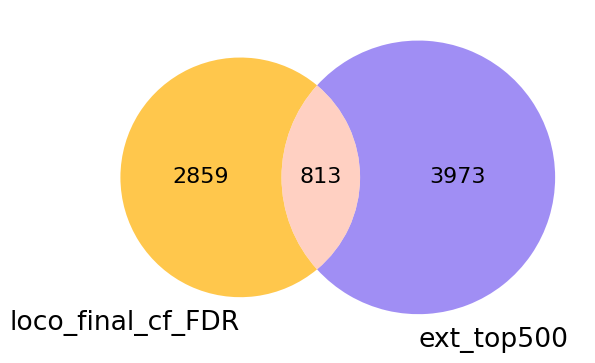

In [63]:
tbl_z=combine_nps_table(NPS_r, NPS_h)
Nr=len(tbl_z[(tbl_z.NPSr>cut_single)])
Nh=len(tbl_z[(tbl_z.NPSc>cut_single)])
Nrh=len(tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)])
Nnet=len(tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)&(tbl_z.NPScr>cut_comb)])

venn2((Nr-Nrh,Nh-Nrh,Nrh), 
      set_labels=(label_r, label_h),
  set_colors=(colour_dict[trait_r],colour_dict[trait_h]), alpha = 0.7)

plt.savefig('figures/network_venn_for_figure'+label_r+'_'+label_h+'.svg',bbox_inches='tight')


## histogram observed vs permuted network size

In [64]:
observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(NPS_r.iloc[:,0], NPS_h.iloc[:,0], 
                                                            z_score_threshold=cut_comb, z1_threshold=cut_single,
                                                            z2_threshold=cut_single, num_reps=10000, plot=False)                                                                   

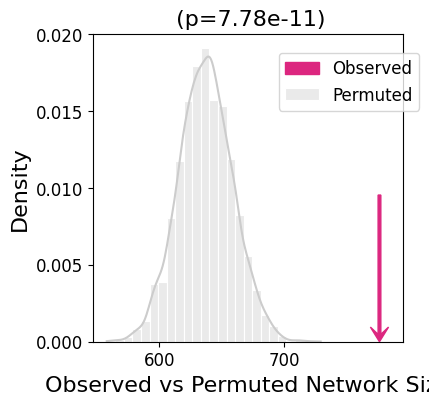

In [65]:
plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict[shared_colour],
                           savefig=save_fig, filename='networksize_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

## histogram observed vs permuted mean NPS

In [66]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(NPS_r.iloc[:,0], NPS_h.iloc[:,0], num_reps=1000,
                                                        zero_double_negatives=False, overlap_control="bin",
                                                        seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", color=colour_dict['other'], arrow_color=colour_dict['shared'],savefig=False, 
                           filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

Overlap seed genes: 8


KeyError: "None of [Index(['57484', '2185', '2555', '166752', '257194', '9785', '1135', '8467'], dtype='object', name=0)] are in the [index]"

Overlap seed genes: 10


100%|██████████| 1000/1000 [00:03<00:00, 269.59it/s]
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1470: RuntimeWarning: invalid value encountered in double_scalars
  sx = self._dy / distance
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  self._y + self._dy,


Cannot round result, p= nan


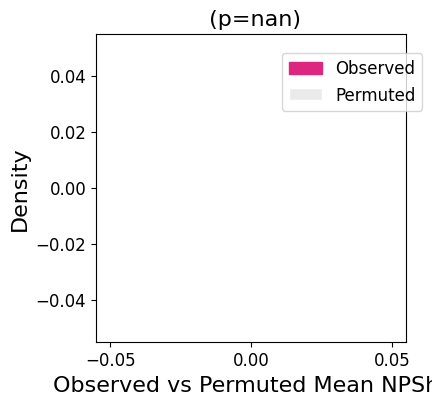

In [249]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(NPS_r.iloc[:,0], NPS_h.iloc[:,0], num_reps=1000,
                                                        zero_double_negatives=False, overlap_control="remove",
                                                        seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", color=colour_dict['other'], arrow_color=colour_dict['shared'],savefig=False, 
                           filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name+'remove')

# sensitivity analysis -NPS scores

In [250]:
if ('netcoloc_enrichment_df' not in vars()):
    netcoloc_enrichment_df=pd.read_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t')

In [251]:
netcoloc_enrichment_df.head()

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp,rat_dataset,human_dataset
0,1,1.0,805,627.41,17.682248,4.911132e-24,1.283053,loco_final_cf_FDR,addict-rf_FDR
1,1,1.5,269,216.20,12.883323,2.080783e-05,1.244218,loco_final_cf_FDR,addict-rf_FDR
2,1,2.0,99,74.00,7.351190,3.359328e-04,1.337838,loco_final_cf_FDR,addict-rf_FDR
3,1,3.0,18,15.16,3.582513,2.139648e-01,1.187335,loco_final_cf_FDR,addict-rf_FDR
4,1,4.0,12,8.61,2.996314,1.289455e-01,1.393728,loco_final_cf_FDR,addict-rf_FDR


In [252]:
netcoloc_enrichment_df['logp']=-np.log10(netcoloc_enrichment_df['empirical_p'])
netcoloc_enrichment_df.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset', 'logp']

In [253]:
temp=netcoloc_enrichment_df[netcoloc_enrichment_df['empirical_p']<0.05/len(netcoloc_enrichment_df)]

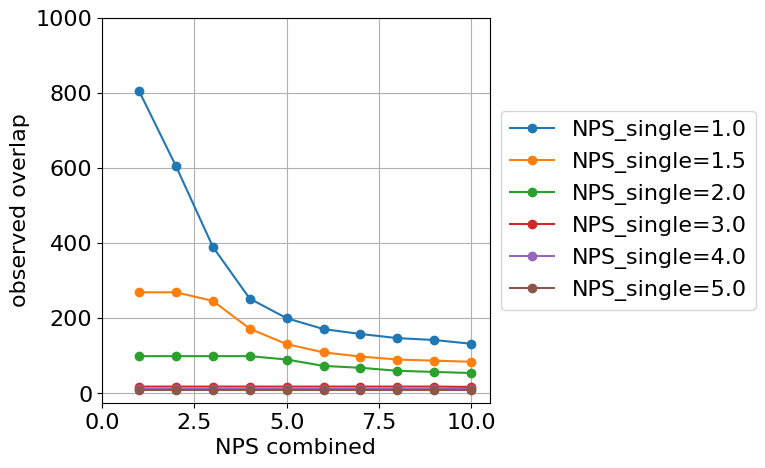

In [254]:
NPS_lineplot(netcoloc_enrichment_df,'observed_overlap','network_overlap_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[-25,1000],savefig=save_fig)

/tmp/ipykernel_1373826/2907217219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


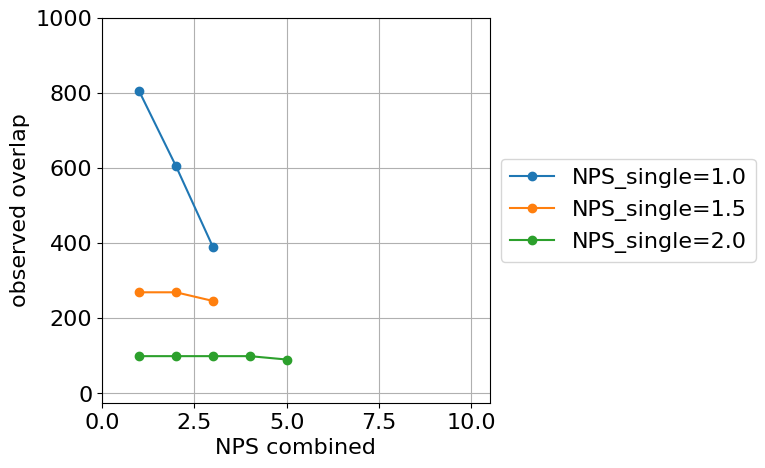

In [255]:
NPS_lineplot(temp,'observed_overlap','network_overlap_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=[-25,1000],savefig=save_fig)

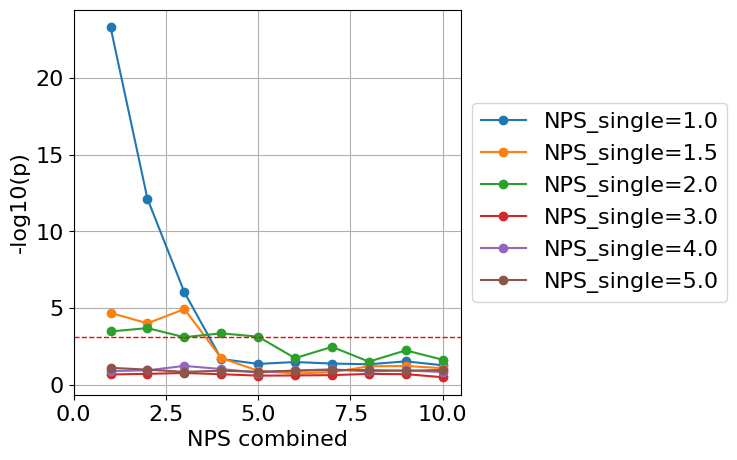

In [256]:
NPS_lineplot(netcoloc_enrichment_df,'-log10(p)','network_overlap_pval_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=None, savefig=save_fig,sigline=True)



/tmp/ipykernel_1373826/2907217219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


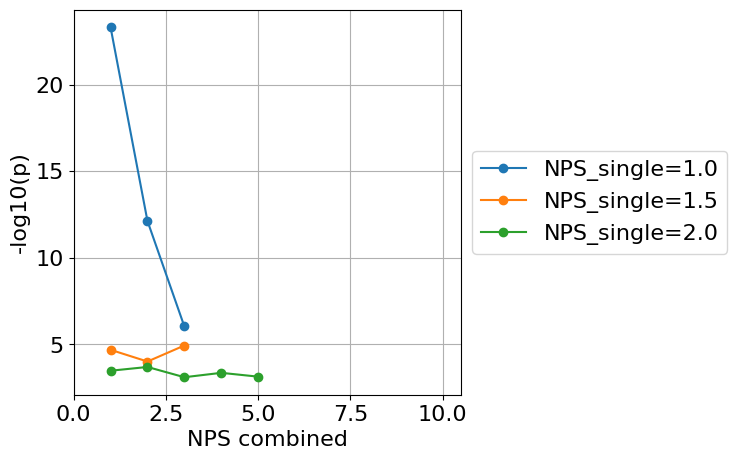

In [257]:
NPS_lineplot(temp,'-log10(p)','network_overlap_pval_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=None,savefig=save_fig)



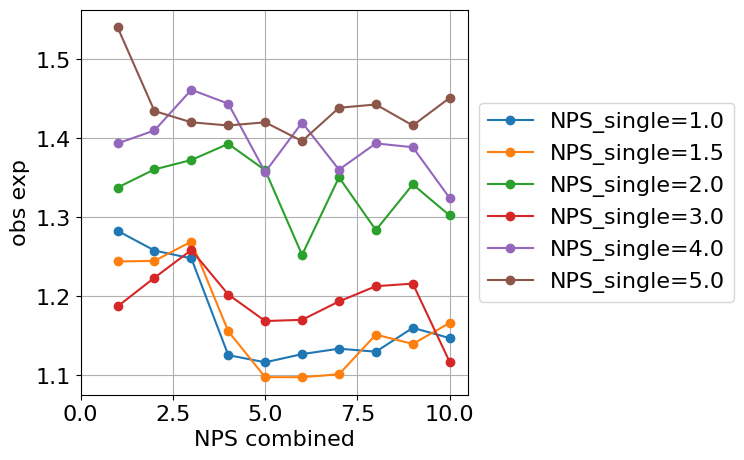

In [258]:
NPS_lineplot(netcoloc_enrichment_df,'obs_exp','network_overlap_obsexp_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=None,savefig=save_fig)

/tmp/ipykernel_1373826/2907217219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


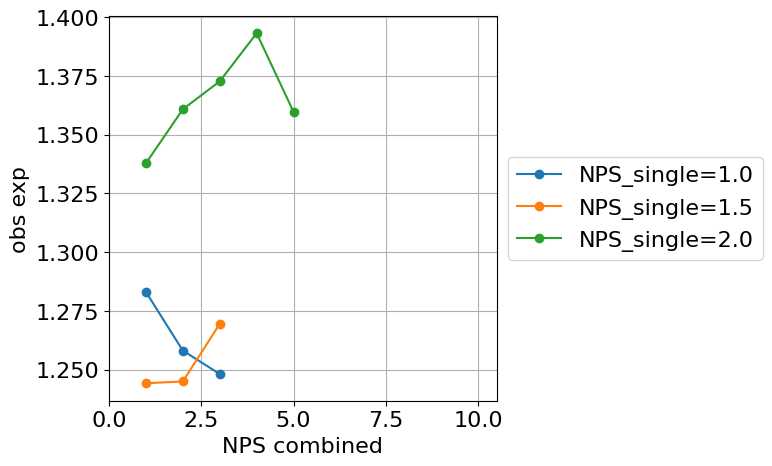

In [259]:
NPS_lineplot(temp,'obs_exp','network_overlap_obsexp_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=None,savefig=save_fig)

# generate colocalized locomotor-ext network (unannotated)- save to ndexbio

In [261]:
net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
print(net2.nodes())
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_MAGMA'), user=ndex_user, password=ndex_password)
    

['SMAD4', 'ACVR2A', 'MAPKAPK2', 'KCNK18', 'MAP3K14', 'SSR3', 'CLIC4', 'GNB4', 'NFKB1', 'SCRIB', 'SDC1', 'NR2C2', 'NDUFB7', 'CHN1', 'MFSD10', 'RAPSN', 'LYN', 'G6PD', 'CCT7', 'PI4KA', 'SMARCA5', 'MINK1', 'ANXA3', 'USP7', 'DPM2', 'AP1G1', 'UPRT', 'CLTA', 'MGAT1', 'DICER1', 'AIP', 'TSC2', 'SLC25A11', 'EDRF1', 'CTBP2', 'HNRNPUL1', 'TRPM4', 'NOS1', 'CDIPT', 'KCNT1', 'CHRNA2', 'SCN1A', 'CHRNB2', 'KCNQ3', 'STXBP1', 'DHX38', 'ZMYND10', 'CCDC40', 'H3C13', 'GABRG1', 'GABRA2', 'SLC6A4', 'DRD2', 'ADRA1A', 'CHRNA3', 'HTR3B', 'DRD4', 'GHR', 'H1-5', 'AP1S2', 'QPCTL', 'H1-1', 'BCDIN3D', 'FNBP4', 'HTR1B', 'DRD3', 'SLC6A2', 'CRHR1', 'GABRA4', 'GRIN2B', 'GRIK3', 'CPA4', 'CD5L', 'RARRES1', 'FEZF2', 'GRIA1', 'GRIK1', 'GABRB3', 'ARX', 'GRIN3A', 'PTPRN', 'LAMP5', 'SHOX2', 'NRXN3', 'CHRNA6', 'NLGN1', 'GRM1', 'GRM7', 'KCNJ4', 'PCDH8', 'GLRA1', 'ZDHHC17', 'KCNA2', 'KCND2', 'DLG2', 'SLC8A2', 'CACNA1E', 'SCN3B', 'VGF', 'PAX4', 'ASIC2', 'CHRM4', 'PAX7', 'KCNJ3', 'KCNB2', 'TRPA1', 'PRSS12', 'LUZP2', 'SCN11A', 'NT5C1